Short Example for use of propagator.py functions to generate JSA and other properties for simple top-hat potential.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from NeedALight.propagator import Hprop, Total_prog, JSA
from thewalrus.quantum.gaussian_checks import is_valid_cov, is_symplectic
from thewalrus.decompositions import blochmessiah, williamson
%config InlineBackend.figure_formats=['svg']

This section introduces all relevant quantities needed to use the functions and generate the wanted properties. Since we are considering an unpoled/unapodized crystal, we simply take the domain to be [1].

In [2]:
#Parameters for calculations

N = 301  # Number of frequency values: Always choose a number ending in 1. That way you always have a frequency value = 0
Np = 0.0172 # Number of pump photons: Vary this to modify gain values
vp = 0.1  # pump velocity
l = 1.0  # amplification region length
sig = 1  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

#Ensuring that we are in the symmetric velocity group matching regime.
def symmetric_v(vp, sig, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sig))
    vs = vp / (1 + 2 * a * vp / (l * sig))
    return vs, vi

vs, vi = symmetric_v(vp, sig, l, a)

#Frequency values
wi = -4
wf = 4
dw = (wf - wi) / (N - 1)
x = np.linspace(wi, wf, N)

#Defining gaussian pump pulse
def pump(x, scale=1):
    return np.exp(-((x) ** 2) / (2 * (sig*scale) ** 2)) / np.power(np.pi * (sig*scale), 1 / 4)


#Unpoled domain
domain = [1]

For the unpoled single pass structure, we can simply make use of all of the functions to generate all the desired/relevant quantities. The JSA function will give us the JSA, the Schmidt number, as well as all the relevant moments. WE also implicitely remove free propagation phases in the functions.We plot the JSA as well. Note that since we only have one domain, we set the final value of the Hprop function to 1. We don't need to precalculate products of 4 domains.

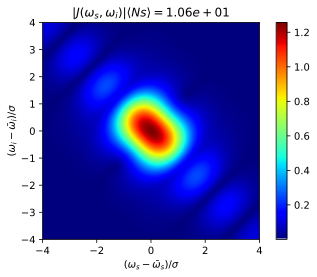

1.0515049079939984


In [3]:
#Generating the JSA
pumpscaled=lambda x: pump(x, scale=1) #Scale is modified with poling, in unpoled case it is simply 1
prod1, P1, Nm1  = Hprop(Np, vs, vi, vp, l, x, pumpscaled,1)  #This generates heisenberg propagators with different signs for length "l"
T1 = Total_prog(domain, prod1, P1, Nm1) #This generates the total propagator given a specific domain.
J, Ns, K, M, Nums, Numi = JSA(T1, vs, vi, vp, l, x) #Generates the JSA as well as other relevant properties.

#Generating plot of JSA
fig, ax = plt.subplots()
im = ax.imshow(J, cmap="jet", origin="lower",extent=[x[0],x[N-1],x[0],x[N-1]])
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
ax.set_title(r"$|J(\omega_{s}, \omega_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()
print(K)

We obtain the Schmidt modes from the N matrix and plot the first relevant mode. Note that we multiply by a phase factor such that the imaginary part is 0 at the origin.

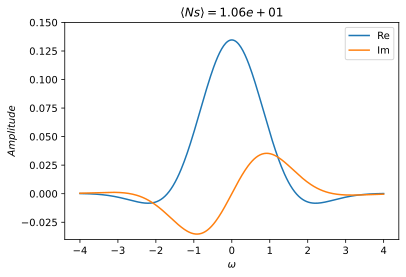

In [4]:
#Looking at the temporal modes via Nums matrix
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val, u = np.linalg.eigh(Nums)

fig, ax1 = plt.subplots()

ax1.plot(x, np.real(np.exp(-1j*np.angle(u[(N-1)//2,-mark]))*u[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(x, np.imag(np.exp(-1j*np.angle(u[(N-1)//2,-mark]))*u[:,-mark]), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.set_ylim([-0.04, 0.15])
ax1.legend()
plt.show()

Here we calculate the fidelity/overlap between a fixed low-gain Schmidt mode and another one with variable gain. We loop over different pump strengths.

In [5]:
#Overlaps and Schmidt number as a function of Np
npi = 0.000002
npf = 0.0184
nstep = 15
step = (npf - npi)/nstep
num_pump = np.arange(npi,npf,step)
nsv = np.zeros_like(num_pump)
K = np.zeros_like(num_pump)
Temp_mode = np.zeros([len(x), len(num_pump)],dtype= np.complex128)
overlap = np.zeros(len(num_pump))


for i in range(np.size(num_pump)):   
    prod1, P1, Nm1  = Hprop(num_pump[i], vs, vi, vp, l, x, pumpscaled,4)
    T1 = Total_prog(domain, prod1, P1, Nm1)
    J, Ns, Ks, M, Nums, Numi = JSA(T1, vs, vi, vp, l, x)

    K[i] = Ks
    nsv[i] = Ns

    w, v = np.linalg.eigh(Nums)
    Temp_mode[:,i] = v[:,-1]
overlapmat = np.abs(np.conj(Temp_mode).T @ Temp_mode) ** 2 #Matrix of all possible overlaps between states at different gains
overlap[:] = overlapmat[0,:] #Overlaps between fixed low level mode and all higher gain modes

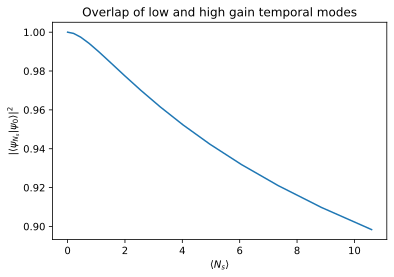

In [6]:
#Plotting Overlap as a function of Ns
fig, ax = plt.subplots()

ax.plot(nsv, overlap)
ax.set_xlabel(r"$\langle N_{s} \rangle$")
ax.set_ylabel(r"$\left| \langle  \psi_{N_{s}}  | \psi_{0}   \rangle \right|^{2}$")
ax.set_title("Overlap of low and high gain temporal modes")
plt.show()
#plt.savefig('SincOverlap.pdf')

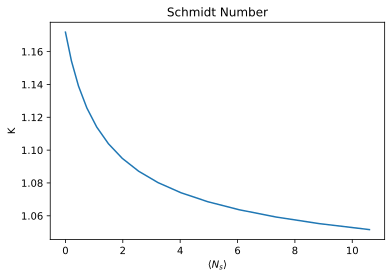

In [7]:
#Plotting Schmidt Number as a function of Ns
fig2, ax2 = plt.subplots()

ax2.plot(nsv, K)
ax2.set_xlabel(r"$\langle N_{s} \rangle$")
ax2.set_ylabel("K")
ax2.set_title("Schmidt Number")
plt.show()

Here we consider how filtering affects the Schmidt modes. Since the JSA is not spectrally pure, more Schmidt modes are relevant. The post-filtered state is then described by a thermal squeezed state. In this section, for a chosen filter width, we look at the thermal and squeezed portions of the filtered Schmidt modes. We plot the first mode here, but one can easily plot whichever mode.

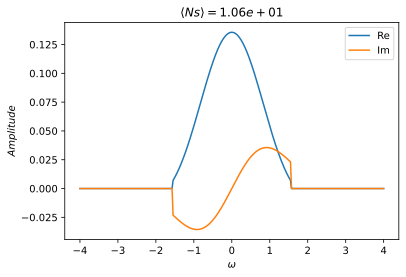

In [8]:
#Filtering Function
filt=np.zeros_like(x)
ind = 92 #Choose the width by varying this. Must be an even number/end in 2.
filt[ind:-ind]=1
filt = np.diag(filt)

#filt = np.eye(len(x))   #If you don't want filtering

Mf = filt @ M @ filt
Numsf = filt @ Nums @ filt
Numif = filt @ Numi @ filt


val3, u3 = np.linalg.eigh(Numsf)
fig, ax1 = plt.subplots()
ax1.plot(x, np.real(np.exp(-1j*np.angle(u3[(N-1)//2,-mark]))*u3[:,-mark]), label='Re')
ax1.plot(x, np.imag(np.exp(-1j*np.angle(u3[(N-1)//2,-mark]))*u3[:,-mark]), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()

Here we construct the covariance matrix in the "xxpp" basis. We output the purity of the filtered state as well as a few sanity checks.

In [9]:
#Constructing the covariance matrix. First we contruct total N and M matrices as well as rotation matrix
N_tot = np.block([[Numsf, 0 * Numsf],[0 * Numif, Numif]])
M_tot = np.block([[0 * Mf, Mf],[Mf.T, 0 * Mf]])
R = (1 / np.sqrt(2)) * np.block([[ np.eye(len(N_tot)), 1j * np.eye(len(N_tot))],[np.eye(len(N_tot)), -1j * np.eye(len(N_tot))]])  #Rotation from a a\dagger basis to X and P

Vf = 2 * np.conj(R).T @ (np.block([[N_tot.T, M_tot], [np.conj(M_tot), N_tot]])+np.eye(len(R))/2) @ R  #Covariance matrix
p = 1 / np.sqrt(np.real(np.linalg.det(Vf))) #this is the purity

Vf = np.real_if_close(Vf)
p, np.allclose(np.imag(Vf), np.zeros_like(Vf)), np.allclose(Vf,Vf.T),is_valid_cov(Vf) #These are sanity checks. For a pure state, as we have here, expect p=1. V should also be real and symmetric.

(0.6018198418614921, True, True, True)

To study the thermal and squeezing parts of the state, we first need to conduct a Williamson decomposition. 

In [10]:
#Williamson Decomposition
#from strawberryfields.decompositions import williamson as will
#D, S = will(Vf)
D, S = williamson(Vf)
is_symplectic(S),np.allclose(S@D@S.T, Vf) #verifying that S is symplectic

(True, True)

From the symplectic matrix obtained by the Williamson decomposition, we then conduct a Bloch-Messiah decomposition.

In [11]:
#Bloch-Messiah Decomposition
uff, dff, vff = blochmessiah(S)
#Sanity checks
np.allclose(uff.T @ uff,np.eye(len(uff))), np.allclose(vff.T @ vff,np.eye(len(vff))), is_symplectic(uff), is_symplectic(vff), np.allclose(uff@dff@vff, S)

(True, True, True, True, True)

Since the Bloch-Messiah outputs a matrix of single mode squeezing, we convert it to a two-mode squeezing by multiplying it with the proper beamsplitter transformation. We isolate the squeezing and thermal portions and then multiply them by a phase factor such that the imaginary part is 0 at the origin (as is done previously when plotting the Schmidt modes). We plot the FIltered Schmidt mode. 

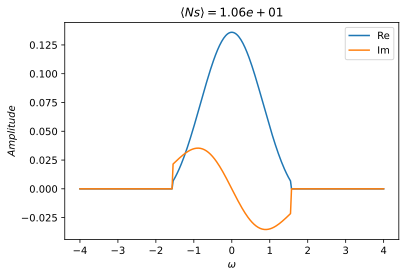

In [12]:
#Constructing the Beam splitter Matrix to form Two mode squeezing
Utransf = (1 / np.sqrt(2)) * np.array([[1, 1j],[1j, 1]])
UU = np.kron(np.eye(len(Vf)//4),Utransf)
O = np.block([[np.real(UU), np.imag(UU)],[-np.imag(UU),np.real(UU)]])

#The properly rotated matrices to obtain filtered state information from
squeezing = uff@O
thermal = np.real_if_close(uff@vff@O)

#Isolating the real and imaginary parts of the Filtered Squeezed state
#To study different mode change the mode_num index. Things are doubly degenerate so 0&1 will be similar.
mode_num=0

#The information of the real and imaginary parts are sometimes output in different sections of the vectors.
#Here we just make sure we choose the right range.
if np.allclose(squeezing[0*N:1*N,mode_num],np.zeros_like(squeezing[0*N:1*N,mode_num])):
    R1=N
    R2=2*N
    R3=3*N
    R4=4*N
else:
    R1=0
    R2=N
    R3=2*N
    R4=3*N


real = np.real_if_close(squeezing[R3:R4,mode_num])
imag = np.real_if_close(squeezing[R1:R2,mode_num])
state = real+1j*imag
phase = -(np.angle(state)) 

#Rotation matrix such that we are in the same frame as the unfiltered modes. I.e. rotation such that imaginary part is 0 at origin
Rotation = np.block([[np.cos(phase[(N-1)//2])*np.eye(2*N),np.sin(phase[(N-1)//2])*np.eye(2*N)],[-np.sin(phase[(N-1)//2])*np.eye(2*N),np.cos(phase[(N-1)//2])*np.eye(2*N)]])
Rsqueezing = Rotation@squeezing

#Isolating Real and Imaginary parts of the Rotated Filtered Squeezed state
Real_Squeezing = np.real_if_close(Rsqueezing[R3:R4,mode_num])
Imag_Squeezing = np.real_if_close(Rsqueezing[R1:R2,mode_num])

#Plotting the Filtered Squeezed state
fig, ax1 = plt.subplots()
ax1.plot(x, Real_Squeezing, label='Re')
ax1.plot(x, Imag_Squeezing, label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
#plt.savefig("Sincmode2lowFilt.pdf")
plt.show()


Here we plot the thermal portion, again by making it such that the imaginary part is 0 at the origin.

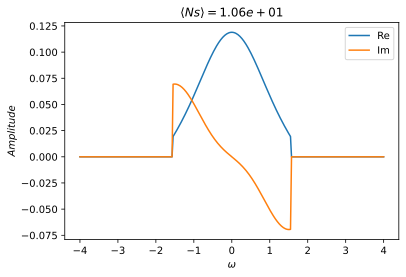

In [13]:
#Isolating the thermal modes. 
#We take the modes at ind//2 because of the way SF Williamson outputs the modes. 
realT = np.real_if_close(thermal[R3:R4,ind//2+mode_num])
imagT = np.real_if_close(thermal[R1:R2,ind//2+mode_num])

Thermal_state = (realT)+1j*(imagT)
norm = np.real_if_close(np.sqrt(np.vdot(Thermal_state,Thermal_state)))
Thermal_state = Thermal_state/norm
Thermal_stateF = np.exp(-1j*np.angle(Thermal_state[(N-1)//2]))*Thermal_state
fig, ax1 = plt.subplots()

ax1.plot(x, np.real(Thermal_stateF), label='Re')
ax1.plot(x, np.imag(Thermal_stateF), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()